In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import multivariate_normal
from sklearn import metrics

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix, classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
pip install kaggle

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d yasserh/breast-cancer-dataset

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes
  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 37.6MB/s]


In [5]:
!unzip breast-cancer-dataset.zip

Archive:  breast-cancer-dataset.zip
  inflating: breast-cancer.csv       


<h2>Data Preparation</h2>


In [46]:
df = pd.read_csv("/content/breast-cancer.csv")

df.head() 

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [19]:
df.shape

(569, 32)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

<h2>Correlation</h2>

In [21]:
# drop unused column

df_corr= df.copy()
df_corr= df_corr.drop("id", axis= "columns")


# make dummy column 

df_corr["diagnosis"]= df_corr["diagnosis"].map({"M": 1, "B": 0})
df_corr= df_corr.rename({"diagnosis": "malignant_cancer"}, axis= "columns")


# make correlation df

data= df_corr.corr()
data_cancer= pd.DataFrame(data["malignant_cancer"]).drop("malignant_cancer", axis= "rows")
data_cancer = data_cancer.sort_values("malignant_cancer", ascending= False)

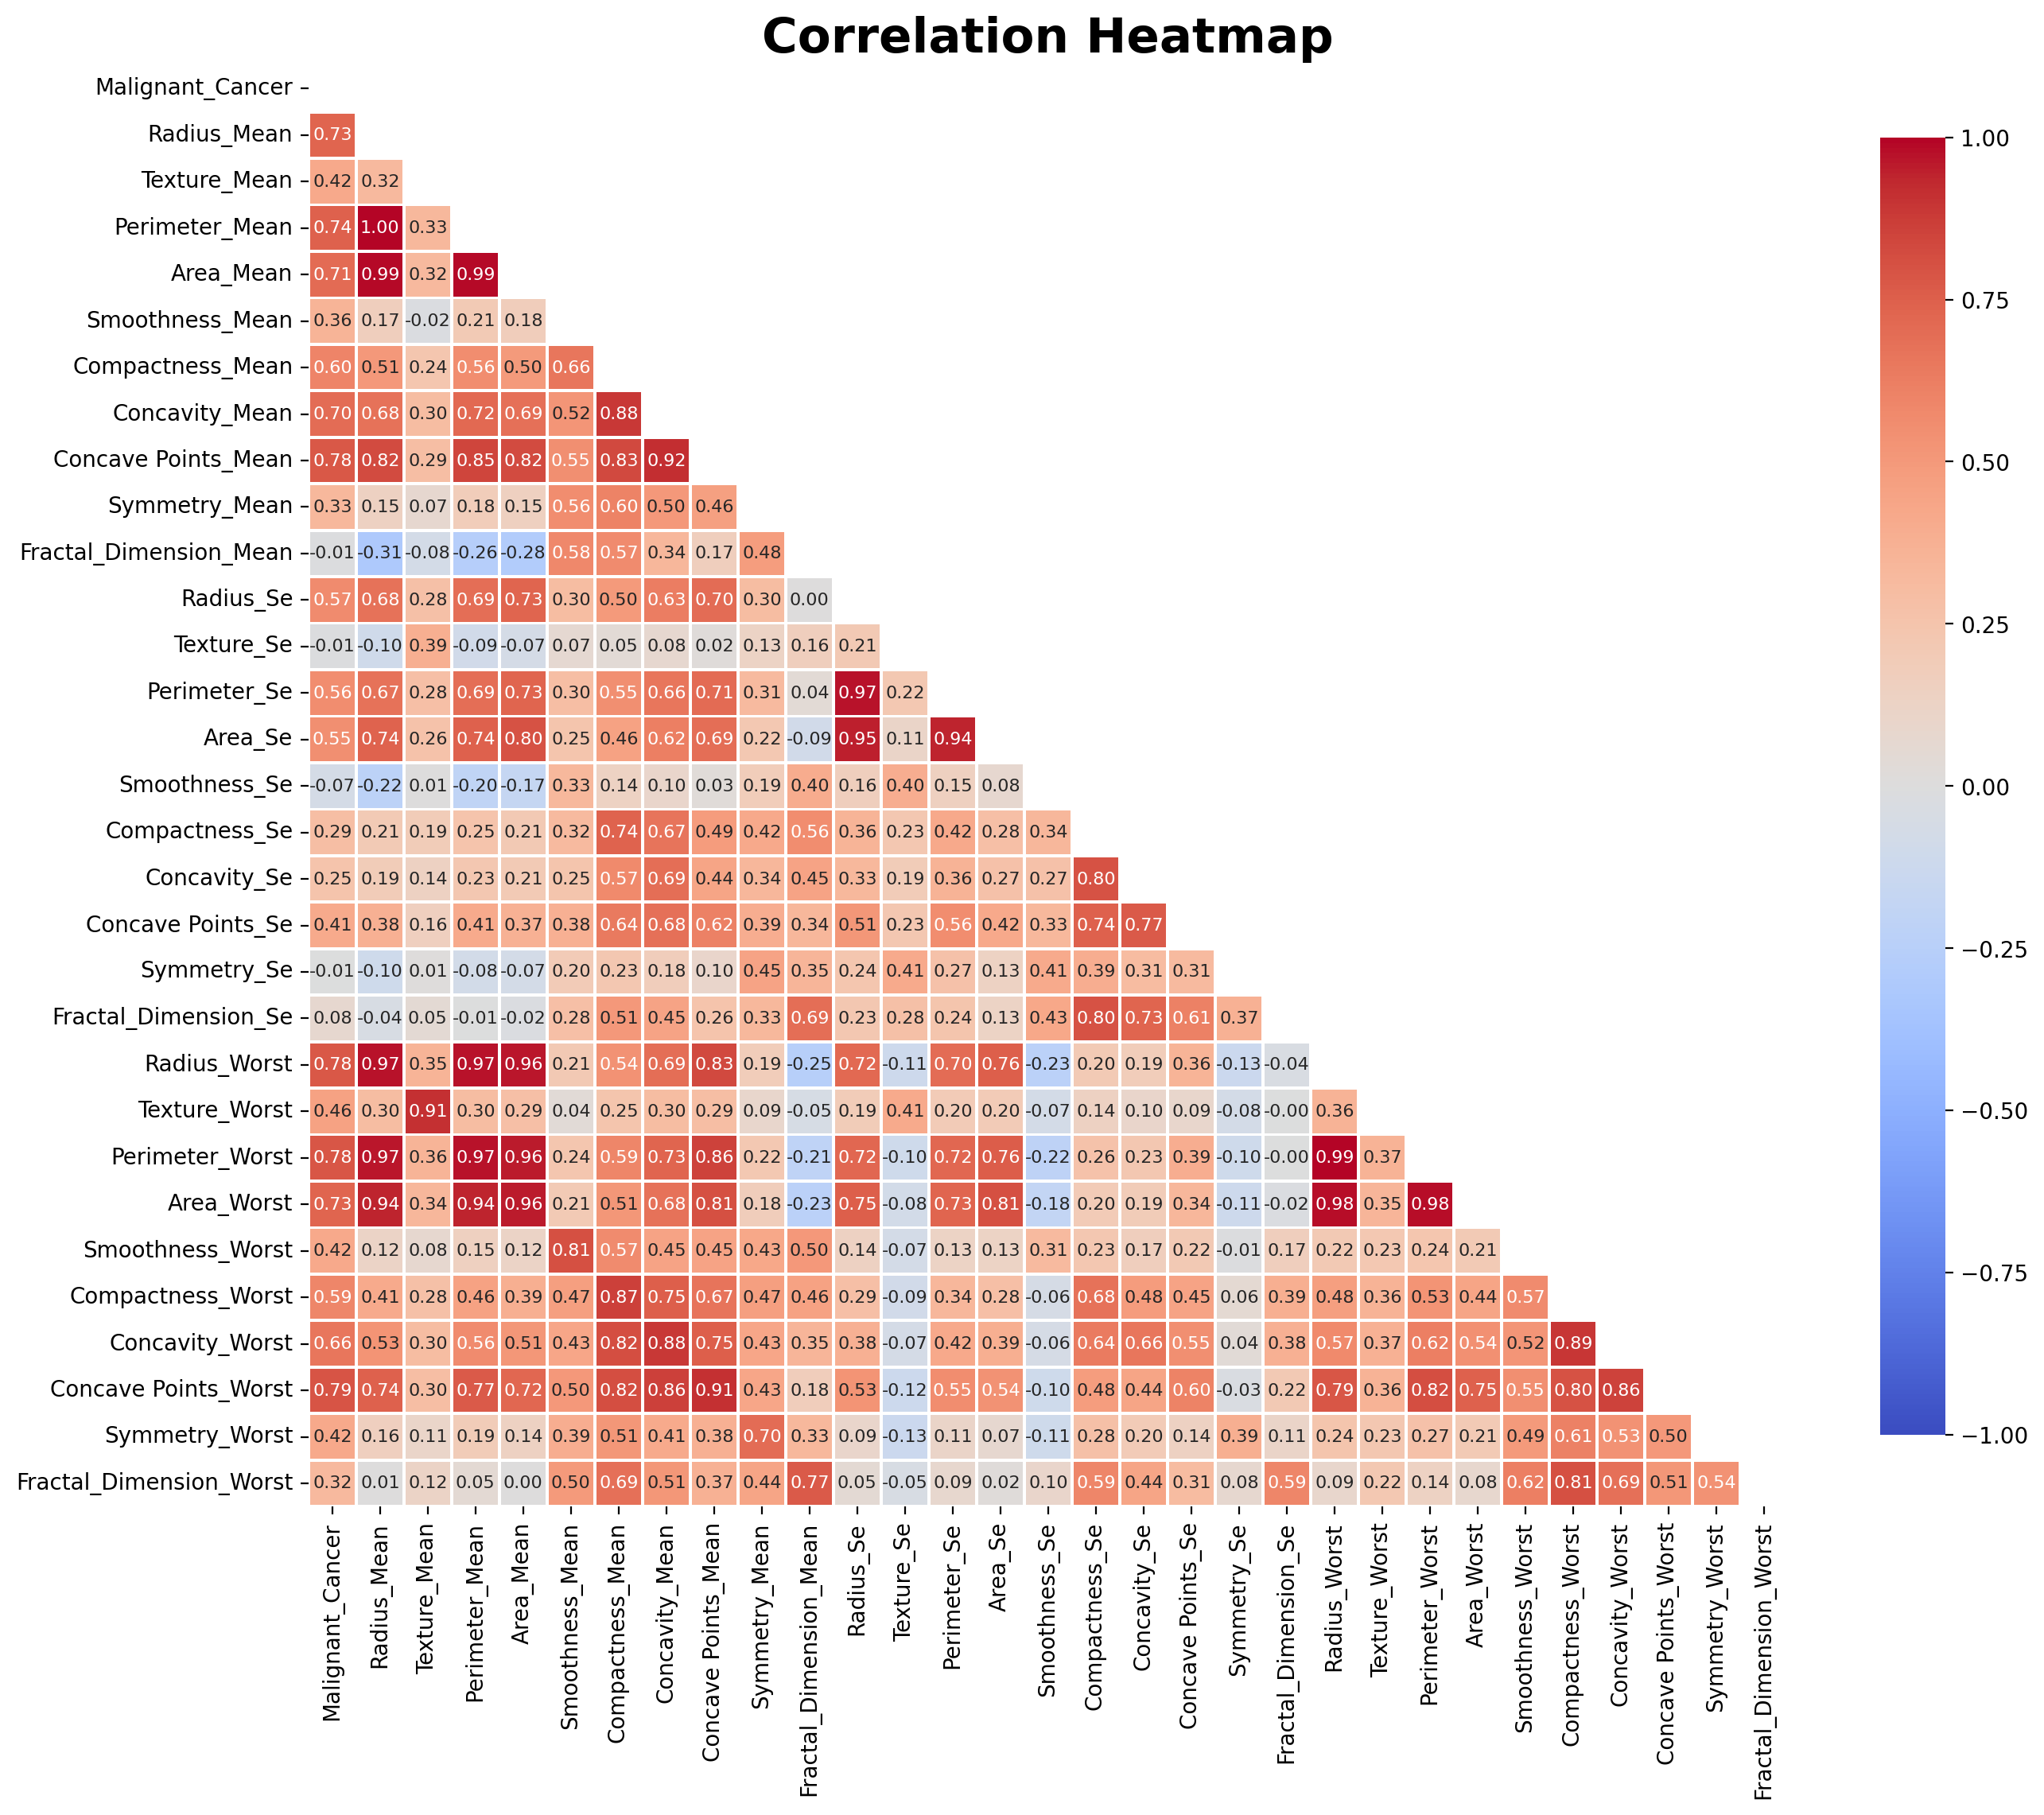

In [22]:
fig, ax = plt.subplots(figsize=(15, 12), dpi= 200)

mask = np.triu(np.ones_like(data, dtype = bool))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(data = data, mask = mask, annot=True, fmt=".2f", cmap=cmap, linewidths= 1, 
            vmin=-1, vmax=1, cbar_kws={"shrink": .9}, annot_kws={"size":8})

yticks = [i.title() for i in data.index]
xticks = [i.title() for i in data.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
plt.title("Correlation Heatmap", fontsize=22, fontweight= "bold")
plt.show()

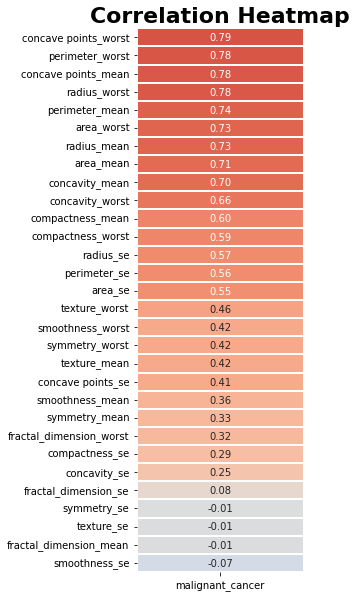

In [23]:
fig, ax = plt.subplots(figsize=(3, 10))

cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(data = data_cancer, annot=True, fmt=".2f", cmap=cmap, linewidths= 1, 
            vmin=-1, vmax=1, cbar= False)

plt.title("Correlation Heatmap", fontsize=22, fontweight= "bold")

plt.show()

<h4>We see that many features correlate strongly with breast cancer. This is a good thing. I assume our ML model will work great knowing this.</h4>

<h2>Count of Label</h2>


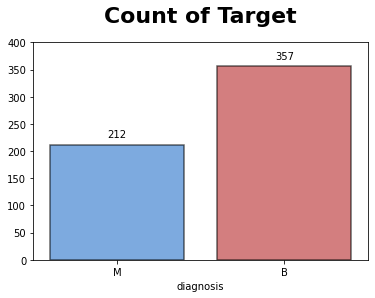

In [24]:
plot= sns.countplot(data= df, x= "diagnosis", palette=['#0b6fe7',"#cf1112"], 
              alpha= 0.6, edgecolor="0", linewidth=1.5)

for bar in plot.patches:
    plot.annotate(format(bar.get_height(), '.0f'),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=10, xytext=(0, 10),
        textcoords='offset points')
    
plt.ylim(0, 400)
plt.title("Count of Target", fontsize=22, fontweight= "bold", pad= 20)
plt.ylabel("")

plt.show()

<h4>The difference is high but not too big. Based on this, I will not say that the data is imbalanced. I'm going to proceed normally.</h4>

<h2>Data preparation</h2>


In [25]:
df= df.rename({"diagnosis": "malignant_cancer"}, axis= "columns")
X= df.drop(["id", "malignant_cancer"], axis= "columns")
y= df["malignant_cancer"]
y= y.map({"M": 1, "B": 0})

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.25, random_state= 100)

In [27]:
scaler= StandardScaler()

scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

<h2>Out-of-box classifier</h2>


In [35]:
class GaussianClassifier:
  def train(self,X,y):
    #class-conditional density - MLE estimate
    self.mean_0 = np.average(X[y==0], axis=0)
    self.mean_1 = np.average(X[y==1], axis=0)
    self.sigma_0 = np.cov(X[y==0], rowvar=False)
    self.sigma_1 = np.cov(X[y==0], rowvar=False)

    #class prior
    self.pi_0 = y[y==0].shape[0]/y.shape[0]
    self.pi_1 = 1.0 - self.pi_0
    
    #multivariate class-conditional density function
    self.prob_0 = multivariate_normal(self.mean_0,self.sigma_0,allow_singular=True)
    self.prob_1 = multivariate_normal(self.mean_1,self.sigma_1,allow_singular=True)

  def predict(self, X):
    preds = []
    for x_input in X:
      #class posterior
      if self.prob_0.pdf(x_input)*self.pi_0 > self.prob_1.pdf(x_input)*self.pi_1:
        preds.append(0)
      else: 
        preds.append(1)
    
    return np.array(preds)

In [43]:
def plot_confusion_matrix(cm, classes,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
cm_plot_labels = ['M', 'B']


Out-of-box prediction accuracy of test data:
0.8741258741258742
Out-of-box confution matrix of test data:


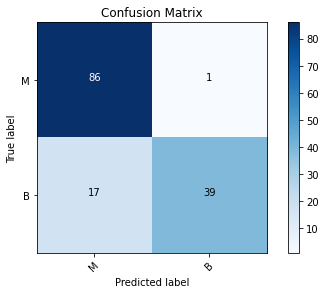

In [59]:
clf = GaussianClassifier()
clf.train(X_train_scaled, y_train)

ypred_test = clf.predict(X_test_scaled)
print("Out-of-box prediction accuracy of test data:")
print(accuracy_score(y_test,ypred_test))

print("Out-of-box confution matrix of test data:")
plot_confusion_matrix(cm=confusion_matrix(y_test,ypred_test), classes=cm_plot_labels, title='Confusion Matrix')

<h4>ROC</h4>
The more that the curve hugs the top left corner of the plot, the better the model does at classifying the data into categories.

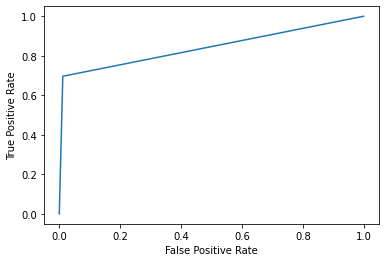

In [63]:
fpr, tpr, _ = metrics.roc_curve(y_test,  ypred_test)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As we can see from the plot above, our model does a great job of classifying the data into categories.

<h4>AUC</h4>
AUC – area under the curve – which tells us how much of the plot is located under the curve.

The closer AUC is to 1, the better the model. A model with an AUC equal to 0.5 is no better than a model that makes random classifications.

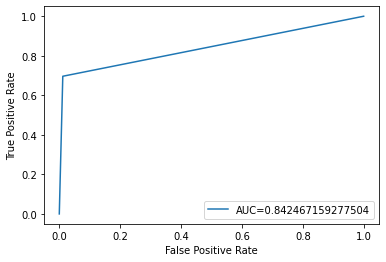

In [64]:
auc = metrics.roc_auc_score(y_test, ypred_test)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The AUC for our model turns out to be 0.842. Since this is pretty close to 1, this confirms that the model does a nice job of classifying data.


<h2>In-box classifier</h2>



In [47]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

GaussianNB()

In-box prediction accuracy of test data:
0.9440559440559441
In-box confution matrix of test data:


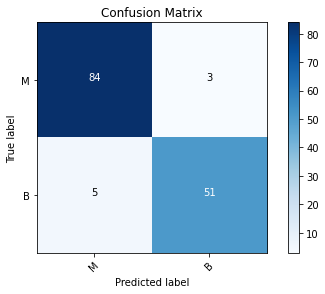

In [54]:
ypred_gnb = nb.predict(X_test_scaled)
print("In-box prediction accuracy of test data:")
print(accuracy_score(y_test,ypred_gnb))

print("In-box confution matrix of test data:")
plot_confusion_matrix(cm=confusion_matrix(y_test,ypred_gnb), classes=cm_plot_labels, title='Confusion Matrix')

<h4>ROC</h4>


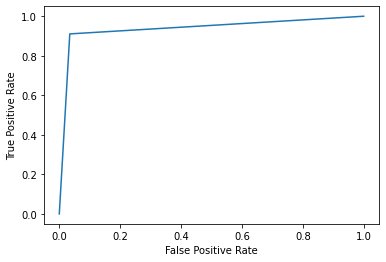

In [65]:
fpr, tpr, _ = metrics.roc_curve(y_test,  ypred_gnb)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As we can see from the plot above, that model does even better job of classifying the data into categories.

<h4>AUC</h4>

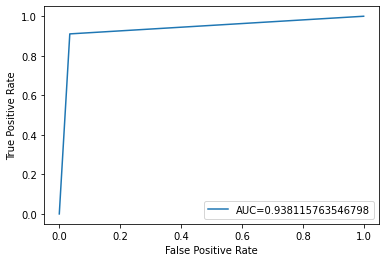

In [66]:
auc = metrics.roc_auc_score(y_test, ypred_gnb)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The AUC for this model turns out to be 0.938. Since this is close to 1, this confirms that the model does a great job of classifying data.